In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("./Dataset/combined_design_dataset.csv")
df.head(10)

,description,font,color_palette
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e"
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90"
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835"
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d"
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc"
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd"
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e"
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9"
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9"
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc"


## Data Cleaning

#### Checking Missing values

In [3]:
df.isnull().sum()

description      0
font             0
color_palette    0
dtype: int64

#### Checking Duplicate values

In [4]:
df.duplicated().sum()

0

#### Data Types

In [5]:
df.dtypes

description      object
font             object
color_palette    object
dtype: object

#### Checking font and color palette consistency

In [6]:
print("Unique Fonts: ", df['font'].nunique())
print("Unique Color Palettes: ", df['color_palette'].nunique())

Unique Fonts:  98
Unique Color Palettes:  63


## Data Preprocessing

In [7]:
font_encoder = LabelEncoder()
df['font_encoded'] = font_encoder.fit_transform(df['font'])

palette_encoder = LabelEncoder()
df['color_palette_encoded'] = palette_encoder.fit_transform(df['color_palette'])

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['description'])
sequences = tokenizer.texts_to_sequences(df['description'])
padded_sequences = pad_sequences(sequences, maxlen=20, padding='post')

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("font_encoder.pkl", "wb") as f:
    pickle.dump(font_encoder, f)
with open("palette_encoder.pkl", "wb") as f:
    pickle.dump(palette_encoder, f)

In [8]:
df['description_sequence'] = list(padded_sequences)
df.head(10)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,"[2, 9, 10, 83, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,"[2, 45, 84, 46, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,"[2, 28, 29, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,"[2, 14, 47, 85, 86, 7, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,"[2, 48, 87, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd",28,49,"[2, 30, 88, 89, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e",51,60,"[2, 49, 90, 50, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",15,14,"[2, 31, 19, 32, 51, 11, 0, 0, 0, 0, 0, 0, 0, 0..."
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",94,14,"[2, 33, 19, 9, 91, 92, 12, 0, 0, 0, 0, 0, 0, 0..."
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc",96,4,"[2, 34, 93, 52, 35, 6, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Exploratory Data Analysis

#### Summary Statistics

In [9]:
print("Dataset Info:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            100 non-null    object
 1   font                   100 non-null    object
 2   color_palette          100 non-null    object
 3   font_encoded           100 non-null    int32 
 4   color_palette_encoded  100 non-null    int32 
 5   description_sequence   100 non-null    object
dtypes: int32(2), object(4)
memory usage: 4.0+ KB
Dataset Info:
 None


In [10]:
print("Font Distribution:\n", df['font'].value_counts().head(10))

Font Distribution:
 font
Chau Philomene One    2
Lacquer               2
Rouge Script          1
Caveat                1
Anta                  1
BIZ UDPGothic         1
Kaisei Opti           1
Moirai One            1
Rubik Mono One        1
Bungee Shade          1
Name: count, dtype: int64


In [11]:
print("Color Palette Distribution:\n", df['color_palette'].value_counts().head(10))

Color Palette Distribution:
 color_palette
#3e61b7,#886a5d,#883f15,#07609e,#ee9fd9    6
#7a48a7,#8130bb,#f51aa4,#78e43a,#9f18db    4
#365a26,#74633a,#d19e27,#61d4e7,#539c58    4
#bcc8a8,#dda9b6,#7875b5,#2d2be2,#9ec046    4
#14af2f,#aac1d3,#5a7d0d,#1ecb92,#65c3d1    3
#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc    3
#01e621,#1e404c,#382607,#4addc2,#da30b2    3
#72cd2f,#740a52,#9b8003,#d0e3f2,#c5e6ab    3
#b96460,#563371,#b78936,#82dc2c,#28b34e    2
#24012c,#d2b08f,#e6e979,#629c5c,#6fcc0e    2
Name: count, dtype: int64


## Feature Engineering

In [12]:
df['description_length'] = df['description'].apply(len)

In [13]:
keywords = ['modern', 'minimalist', 'vintage', 'bold', 'elegant']
for keyword in keywords:
    df[f'contains_{keyword}'] = df['description'].apply(lambda x: 1 if keyword in x.lower() else 0)

In [14]:
df['palette_complexity'] = df['color_palette'].apply(lambda x: len(set(x.split(','))))

In [15]:
df.head(10)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence,description_length,contains_modern,contains_minimalist,contains_vintage,contains_bold,contains_elegant,palette_complexity
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,"[2, 9, 10, 83, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",29,1,0,0,0,0,5
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,"[2, 45, 84, 46, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",26,0,0,1,0,0,5
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,"[2, 28, 29, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",34,0,1,0,0,0,5
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,"[2, 14, 47, 85, 86, 7, 0, 0, 0, 0, 0, 0, 0, 0,...",33,0,0,0,0,0,5
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,"[2, 48, 87, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",22,0,0,0,0,0,5
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd",28,49,"[2, 30, 88, 89, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",41,0,0,0,0,0,5
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e",51,60,"[2, 49, 90, 50, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",31,0,0,0,0,0,5
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",15,14,"[2, 31, 19, 32, 51, 11, 0, 0, 0, 0, 0, 0, 0, 0...",31,0,0,0,1,0,5
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",94,14,"[2, 33, 19, 9, 91, 92, 12, 0, 0, 0, 0, 0, 0, 0...",39,1,0,0,0,0,5
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc",96,4,"[2, 34, 93, 52, 35, 6, 0, 0, 0, 0, 0, 0, 0, 0,...",36,0,0,0,0,0,5


## Visualizations

#### Font Distribution

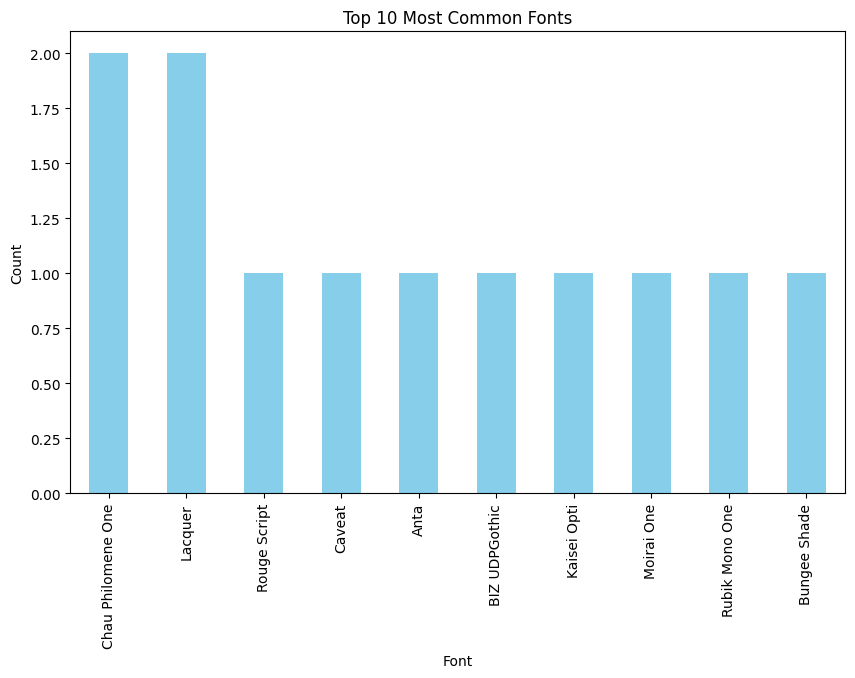

In [16]:
plt.figure(figsize=(10, 6))
df['font'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Most Common Fonts")
plt.xlabel("Font")
plt.ylabel("Count")
plt.show()

#### Color Palette Popularity

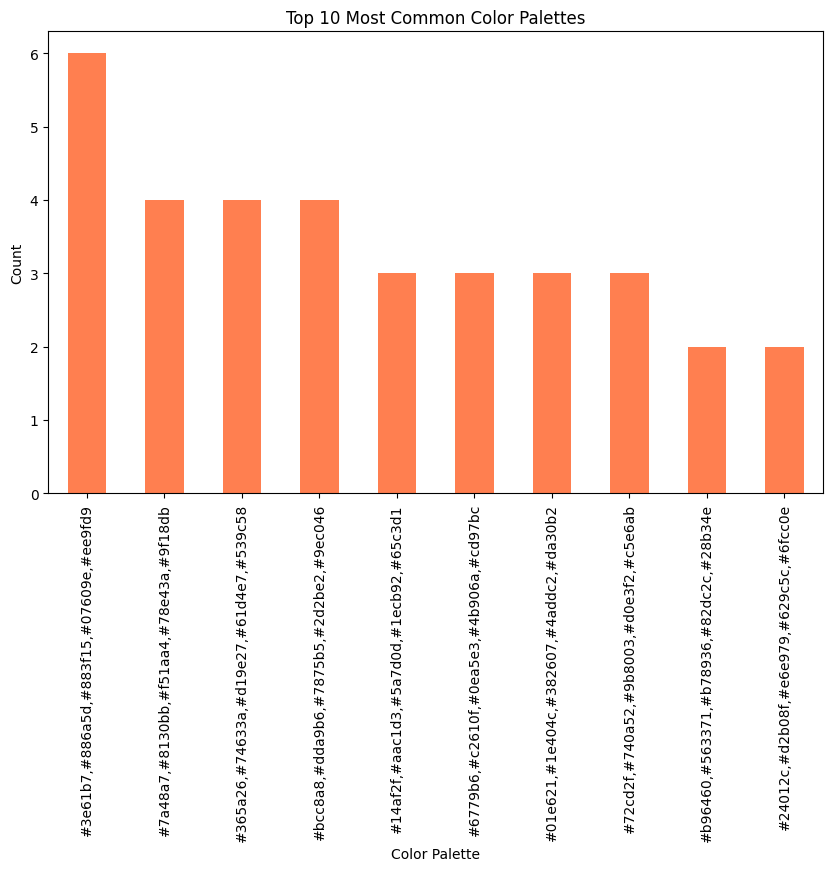

In [17]:
plt.figure(figsize=(10, 6))
df['color_palette'].value_counts().head(10).plot(kind='bar', color='coral')
plt.title("Top 10 Most Common Color Palettes")
plt.xlabel("Color Palette")
plt.ylabel("Count")
plt.show()

#### Word Cloud for descriptions

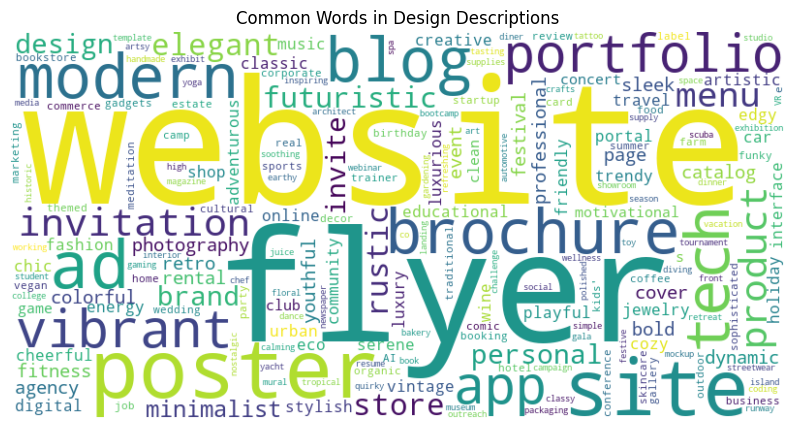

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['description']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Design Descriptions")
plt.show()

#### Box plot of description length

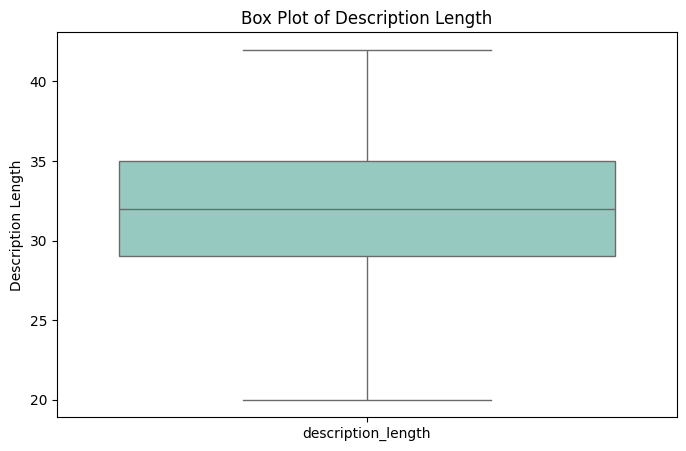

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['description_length']], palette='Set3')
plt.title('Box Plot of Description Length')
plt.ylabel('Description Length')
plt.show()

#### Clustering: Font and Color Palette encoding

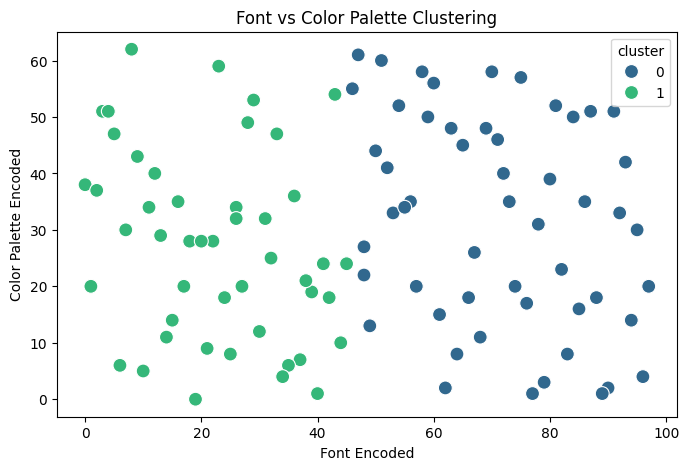

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['font_encoded', 'color_palette_encoded']])

plt.figure(figsize=(8, 5))
sns.scatterplot(x='font_encoded', y='color_palette_encoded', hue='cluster', data=df, palette='viridis', s=100)
plt.title('Font vs Color Palette Clustering')
plt.xlabel('Font Encoded')
plt.ylabel('Color Palette Encoded')
plt.show()

In [21]:
df.to_csv("./Dataset/cleaned_combined_dataset.csv", index=False)
print("Cleaned dataset saved.")

Cleaned dataset saved.


#### Loading the cleaned dataset

In [22]:
dataset = pd.read_csv('./Dataset/cleaned_combined_dataset.csv')
dataset.head(10)

,description,font,color_palette,font_encoded,color_palette_encoded,description_sequence,description_length,contains_modern,contains_minimalist,contains_vintage,contains_bold,contains_elegant,palette_complexity,cluster
0,A modern tech startup website,Rouge Script,"#b96460,#563371,#b78936,#82dc2c,#28b34e",84,50,[ 2 9 10 83 4 0 0 0 0 0 0 0 0 0 0 ...,29,1,0,0,0,0,5,0
1,A vintage coffee shop menu,Patua One,"#35ae97,#4917e8,#3edec7,#2d0b25,#f8bb90",76,17,[ 2 45 84 46 18 0 0 0 0 0 0 0 0 0 0 ...,26,0,0,1,0,0,5,0
2,A minimalist photography portfolio,Numans,"#a90421,#cd8643,#dc2b6c,#10c5bb,#15c835",71,46,[ 2 28 29 13 0 0 0 0 0 0 0 0 0 0 0 ...,34,0,1,0,0,0,5,0
3,A vibrant fashion e-commerce site,Bangers,"#68f006,#e8aca2,#01b2fe,#f07642,#aa299d",13,29,[ 2 14 47 85 86 7 0 0 0 0 0 0 0 0 0 ...,33,0,0,0,0,0,5,1
4,A cozy bookstore flyer,Brawler,"#6779b6,#c2610f,#0ea5e3,#4b906a,#cd97bc",18,28,[ 2 48 87 5 0 0 0 0 0 0 0 0 0 0 0 ...,22,0,0,0,0,0,5,1
5,A professional corporate business website,Delius Unicase,"#b7ee81,#8e29cd,#7aa04c,#004ddd,#6a04cd",28,49,[ 2 30 88 89 4 0 0 0 0 0 0 0 0 0 0 ...,41,0,0,0,0,0,5,1
6,A playful kids' educational app,Linefont,"#e88eb6,#21dd51,#8c771e,#f6386b,#715d9e",51,60,[ 2 49 90 50 15 0 0 0 0 0 0 0 0 0 0 ...,31,0,0,0,0,0,5,0
7,A bold and colorful travel blog,Belgrano,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",15,14,[ 2 31 19 32 51 11 0 0 0 0 0 0 0 0 0 ...,31,0,0,0,1,0,5,1
8,A sleek and modern real estate brochure,Water Brush,"#317734,#c586d7,#d2d66d,#81d385,#f067a9",94,14,[ 2 33 19 9 91 92 12 0 0 0 0 0 0 0 0 ...,39,1,0,0,0,0,5,0
9,A retro-themed music festival poster,Zhi Mang Xing,"#0580b1,#2a2e61,#35f598,#79f619,#946cdc",96,4,[ 2 34 93 52 35 6 0 0 0 0 0 0 0 0 0 ...,36,0,0,0,0,0,5,0
